# Ocean stats

In [344]:
from mom6_tools.DiagsCase import DiagsCase
import os, yaml
import pandas as pd
import glob
import xarray
import cftime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

In [328]:
# Read in the yaml file
diag_config_yml_path = "diag_config.yml"
diag_config_yml = yaml.load(open(diag_config_yml_path,'r'), Loader=yaml.Loader)

In [352]:
# Create the case instance
dcase = DiagsCase(diag_config_yml['Case'])
print('Casename is:', dcase.casename)
RUNDIR = dcase.get_value('RUNDIR')
all_files = glob.glob(os.path.join(RUNDIR, "ocean.stats"))

Casename is: bmom.e20.BMOM.f09_t061.long_run_mct.003


In [331]:
colnames = ['Step','Day','Truncs','Energy/Mass','Maximum CFL', 'Mean Sea Level', 'Total Mass', 'Mean Salin', 'Mean Temp', 'Frac Mass Err', 'Salin Err', 'Temp Err']
units = ['nondim','days','nondim','m2 s-2','nondim', 'm', 'kg', 'PSU', 'degC', 'nondim', 'PSU', 'degC']

In [332]:
df = pd.read_csv(all_files[0], header=1, error_bad_lines=False, sep=',',  names = colnames) 

In [333]:
df.head(10)

,Step,Day,Truncs,Energy/Mass,Maximum CFL,Mean Sea Level,Total Mass,Mean Salin,Mean Temp,Frac Mass Err,Salin Err,Temp Err
0,0,0.0,0,En 2.4059209241026638E-23,CFL 0.00000,SL -1.3527E-10,M 1.38612E+21,S 34.7202,T 3.5889,Me 0.00E+00,Se 0.00E+00,Te 0.00E+00
1,23,1.0,0,En 8.2743180513478653E-04,CFL 0.04485,SL -1.3527E-10,M 1.38612E+21,S 34.7202,T 3.5889,Me 3.57E-19,Se -1.09E-16,Te 2.56E-17
2,47,2.0,0,En 8.7846356062311630E-04,CFL 0.03130,SL -1.3599E-10,M 1.38612E+21,S 34.7202,T 3.5889,Me 5.35E-20,Se 1.26E-17,Te -2.08E-18
3,71,3.0,0,En 9.4306204845940505E-04,CFL 0.03441,SL -1.3812E-10,M 1.38612E+21,S 34.7202,T 3.5889,Me -2.73E-20,Se -7.22E-17,Te -2.65E-18
4,95,4.0,0,En 9.1351088700994366E-04,CFL 0.04201,SL -1.3670E-10,M 1.38612E+21,S 34.7202,T 3.5890,Me 2.95E-19,Se 4.47E-17,Te -1.94E-18
5,119,5.0,0,En 9.0563027717253356E-04,CFL 0.05128,SL -1.3670E-10,M 1.38612E+21,S 34.7202,T 3.5890,Me -4.47E-19,Se -5.82E-17,Te 1.37E-18
6,143,6.0,0,En 9.0522282366327074E-04,CFL 0.05175,SL -1.3527E-10,M 1.38612E+21,S 34.7202,T 3.5890,Me 2.07E-19,Se -5.15E-17,Te -2.42E-18
7,167,7.0,0,En 8.9818790786723619E-04,CFL 0.05526,SL -1.3456E-10,M 1.38612E+21,S 34.7202,T 3.5890,Me -5.04E-19,Se -7.47E-17,Te 3.32E-18
8,191,8.0,0,En 8.8772431618516128E-04,CFL 0.04987,SL -1.3456E-10,M 1.38612E+21,S 34.7202,T 3.5890,Me -2.05E-19,Se 2.07E-18,Te -7.07E-18
9,215,9.0,0,En 8.9332467522302899E-04,CFL 0.05356,SL -1.3527E-10,M 1.38612E+21,S 34.7202,T 3.5890,Me 1.27E-19,Se -5.30E-17,Te 1.62E-18


In [321]:
# transfor to xarray and change/rename the coords
xr = df.to_xarray()
del xr['index'], xr['Step']
xr = xr.rename({'index': 'Day'})
xr.set_coords('Day')

<xarray.Dataset>
Dimensions:         (Day: 21145)
Coordinates:
  * Day             (Day) float64 0.0 1.0 2.0 ... 1.892e+04 1.892e+04 1.892e+04
Data variables:
    Truncs          (Day) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    Energy/Mass     (Day) object 2.406e-23 0.0008171 ... 0.0008852 0.0008915
    Maximum CFL     (Day) object 0.0 0.0369 0.04692 ... 0.04421 0.04214 0.04184
    Mean Sea Level  (Day) object -1.353e-10 -1.331e-10 ... -1.303e-10 -1.317e-10
    Total Mass      (Day) object 1.386e+21 1.386e+21 ... 1.386e+21 1.386e+21
    Mean Salin      (Day) object 34.72 34.72 34.72 34.72 ... 34.72 34.72 34.72
    Mean Temp       (Day) object 3.589 3.589 3.589 3.589 ... 3.553 3.553 3.553
    Frac Mass Err   (Day) object 0.0 6.35e-20 -4.4e-19 ... -7.29e-20 2.04e-19
    Salin Err       (Day) object 0.0 4.33e-14 -4.94e-17 ... -6.28e-17 -7.39e-17
    Temp Err        (Day) object 0.0 2.56e-17 -5.97e-18 ... -1.64e-18 -4.27e-18

In [322]:
# add attrs units
k = 1
for var in xr.variables:
    print(var,k, units[k])
    xr[var].attrs['units'] = units[k]
    k = k + 1

Day 1 days
Truncs 2 nondim
Energy/Mass 3 m2 s-2
Maximum CFL 4 nondim
Mean Sea Level 5 m
Total Mass 6 kg
Mean Salin 7 PSU
Mean Temp 8 degC
Frac Mass Err 9 nondim
Salin Err 10 PSU
Temp Err 11 degC


### Some columns have strings in them (e.g., CFL and En) and we need to remove them.

In [287]:
colnames = ['Energy/Mass','Maximum CFL', 'Mean Sea Level', 'Total Mass', 'Mean Salin', 'Mean Temp', 'Frac Mass Err', 'Salin Err', 'Temp Err']

for var in colnames:
  print(var)
  nt = len(xr[var])
  dummy = np.zeros(nt)
  for t in range(nt):
    dummy[t] = float(str(xr[var][t].values).strip().split()[1])
    
  xr[var].values[:] = dummy[:]

Energy/Mass
Maximum CFL
Mean Sea Level
Total Mass
Mean Salin
Mean Temp
Frac Mass Err
Salin Err
Temp Err


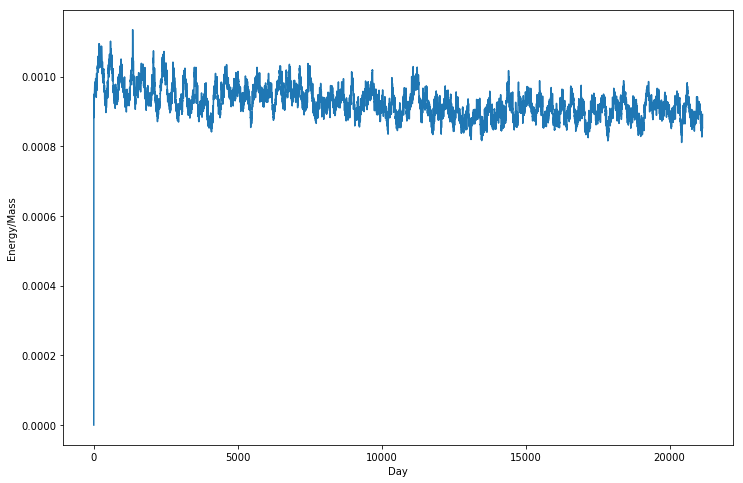

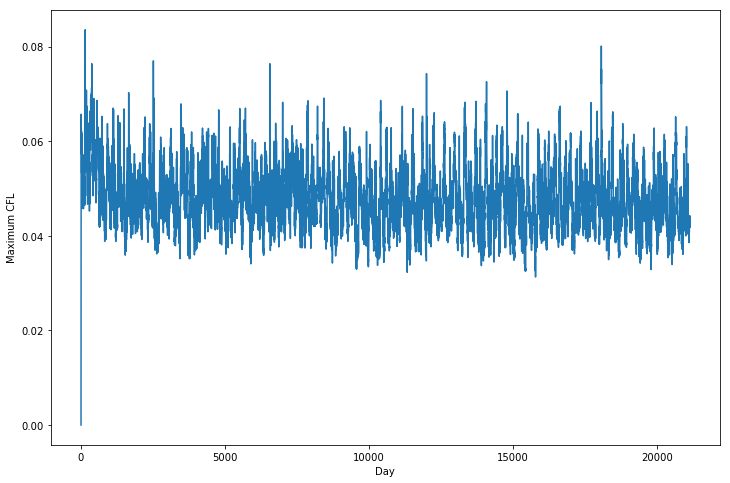

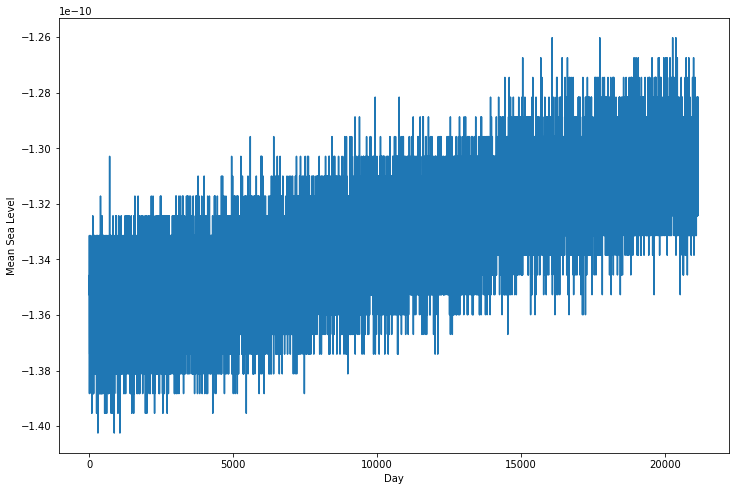

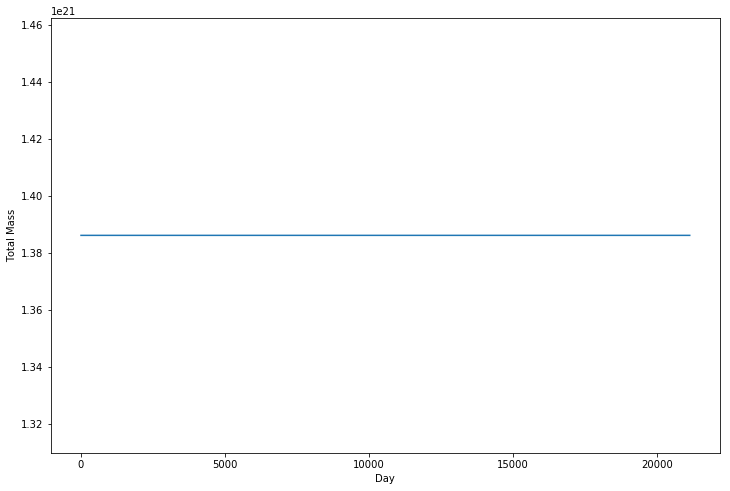

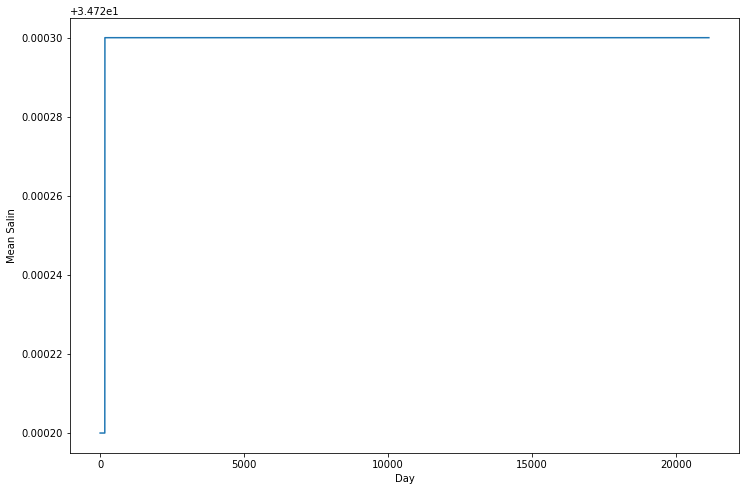

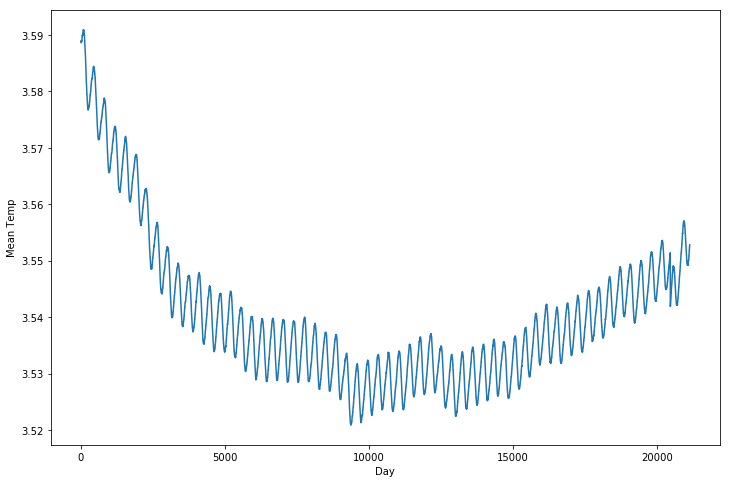

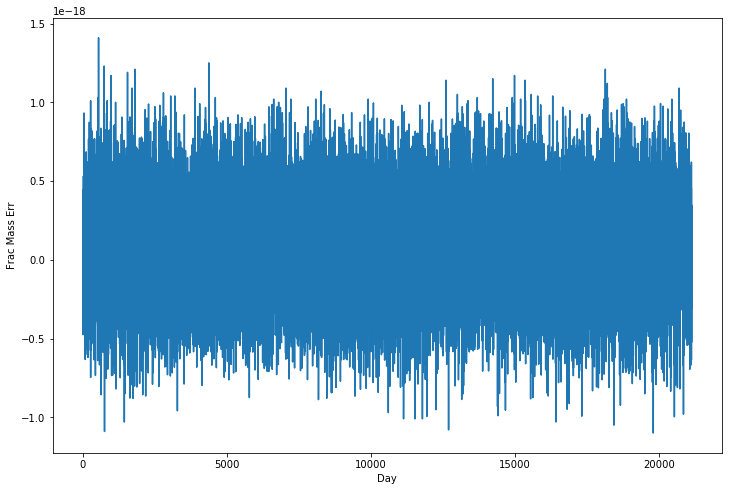

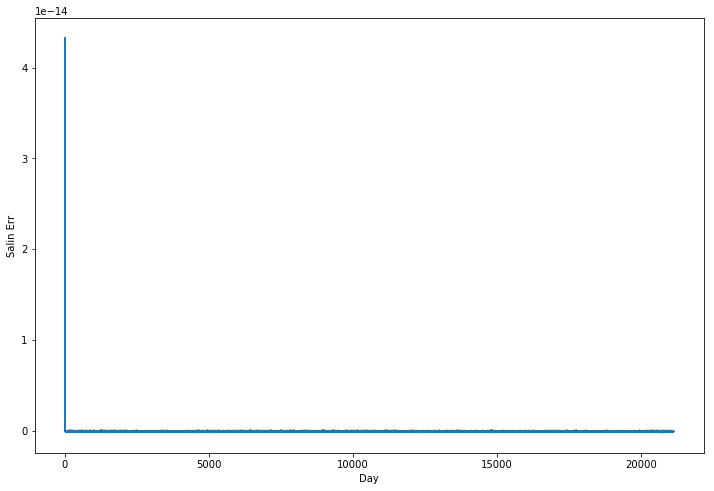

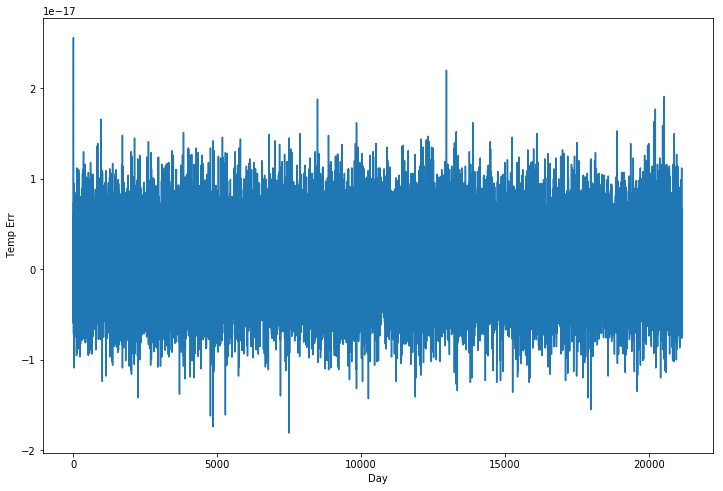

In [319]:
xr = xr.astype(float)
xr.set_coords('Day')
#xr['Day'] = xr['Day']/365.
for var in colnames:
    plt.figure(figsize=(12,8))
    xr[var].plot()

In [349]:
df_stats = xarray.open_dataset(RUNDIR+'/ocean.stats.nc')
df_stats

<xarray.Dataset>
Dimensions:        (Interface: 64, Layer: 63, Time: 33716)
Coordinates:
  * Layer          (Layer) float64 1.25 3.75 6.25 ... 5.125e+03 5.625e+03
  * Interface      (Interface) float64 0.0 2.5 5.0 7.5 ... 5e+03 5.25e+03 6e+03
  * Time           (Time) timedelta64[ns] 0 days 1 days ... 31025 days
Data variables:
    Ntrunc         (Time) float64 ...
    En             (Time) float64 ...
    APE            (Time, Interface) float64 ...
    KE             (Time, Layer) float64 ...
    H0             (Time, Interface) float64 ...
    Mass_lay       (Time, Layer) float64 ...
    Mass           (Time) float64 ...
    Mass_chg       (Time) float64 ...
    Mass_anom      (Time) float64 ...
    max_CFL_trans  (Time) float64 ...
    max_CFL_lin    (Time) float64 ...
    Salt           (Time) float64 ...
    Salt_chg       (Time) float64 ...
    Salt_anom      (Time) float64 ...
    Heat           (Time) float64 ...
    Heat_chg       (Time) float64 ...
    Heat_anom      (Time) 

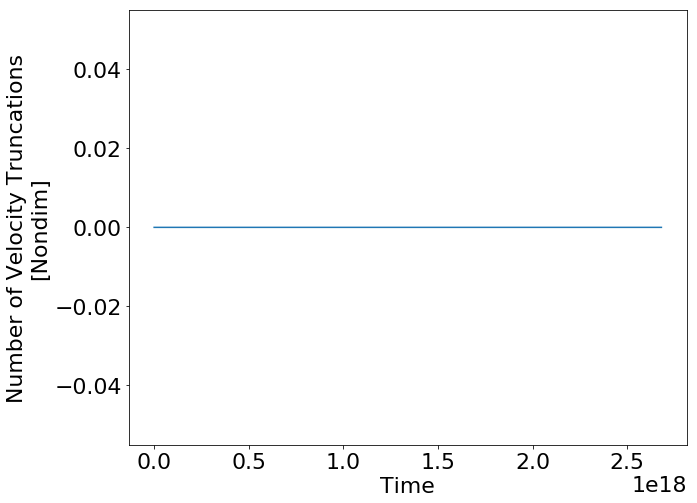

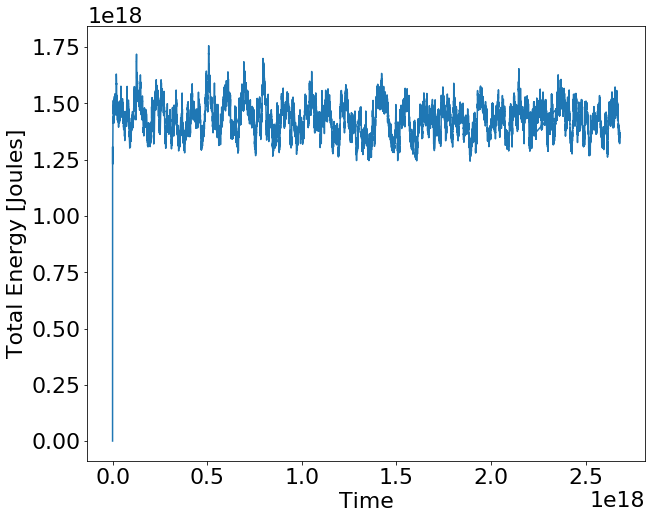

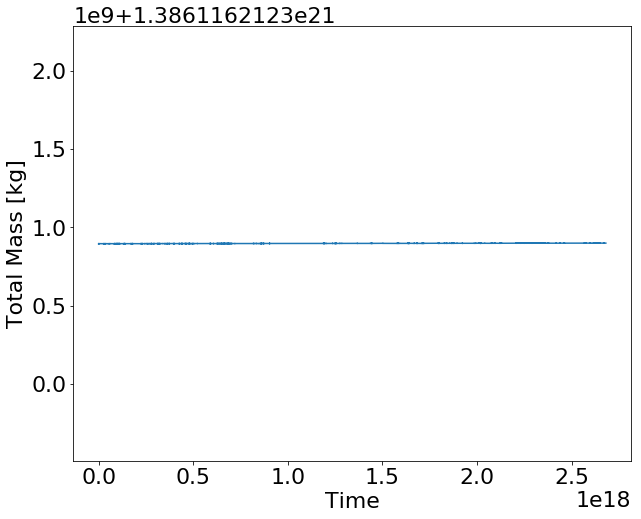

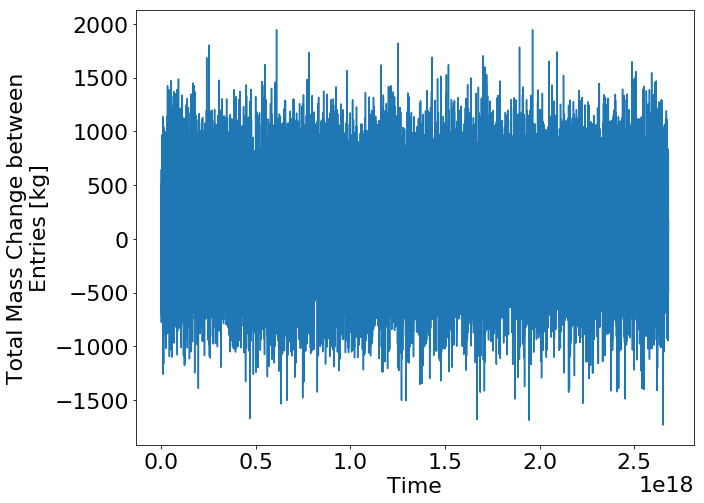

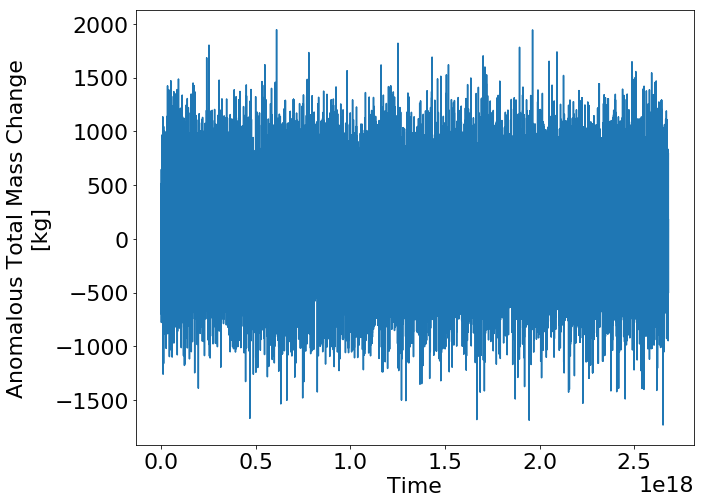

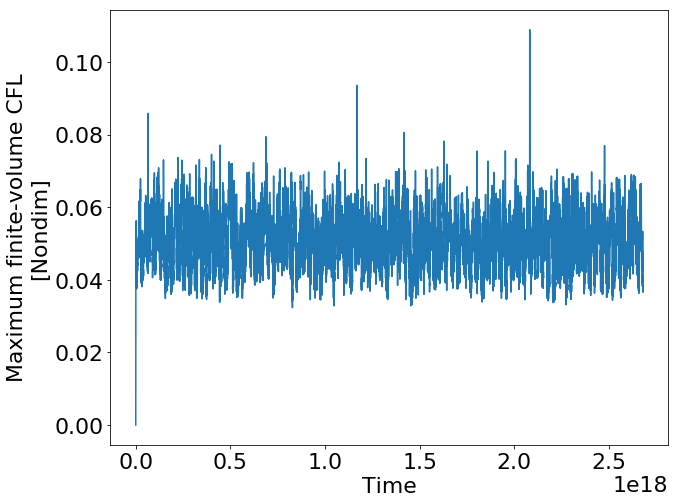

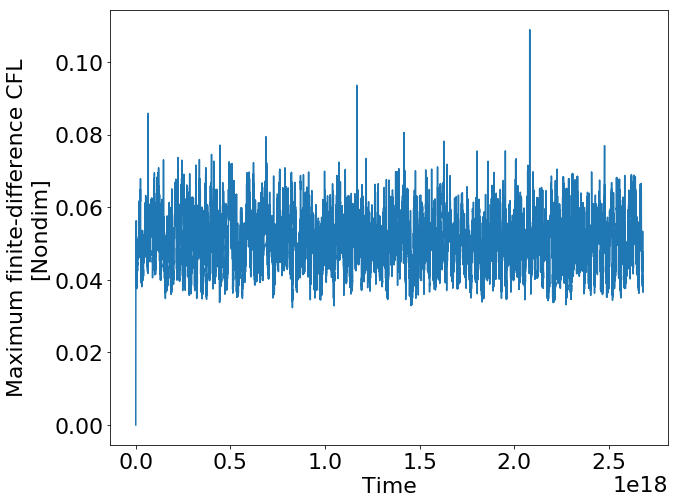

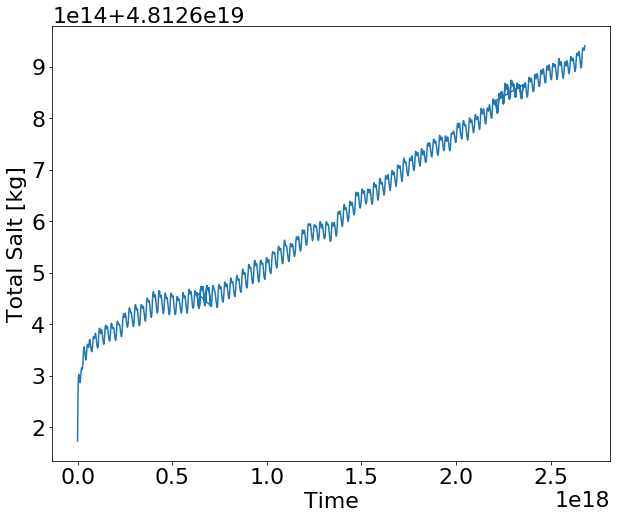

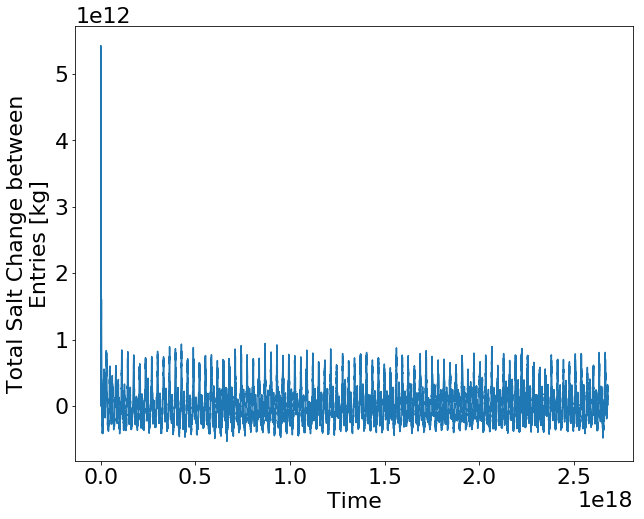

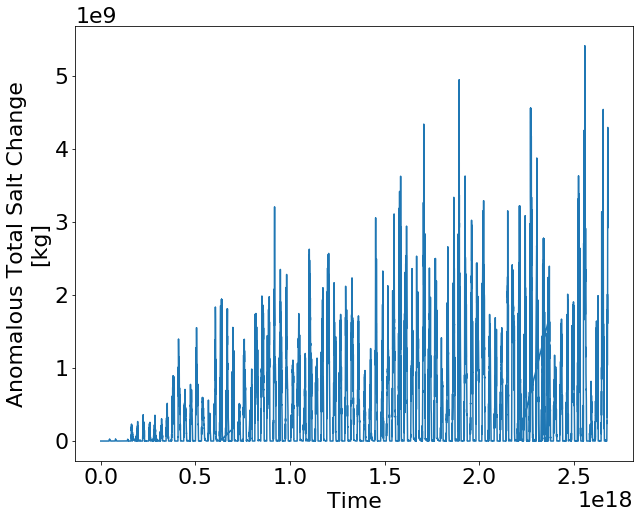

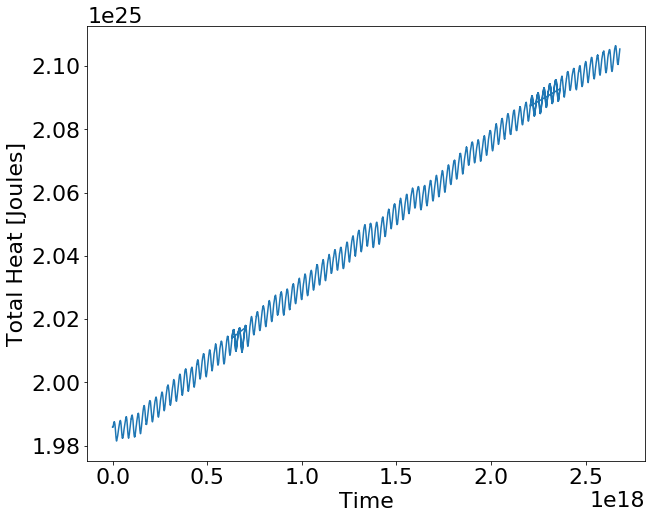

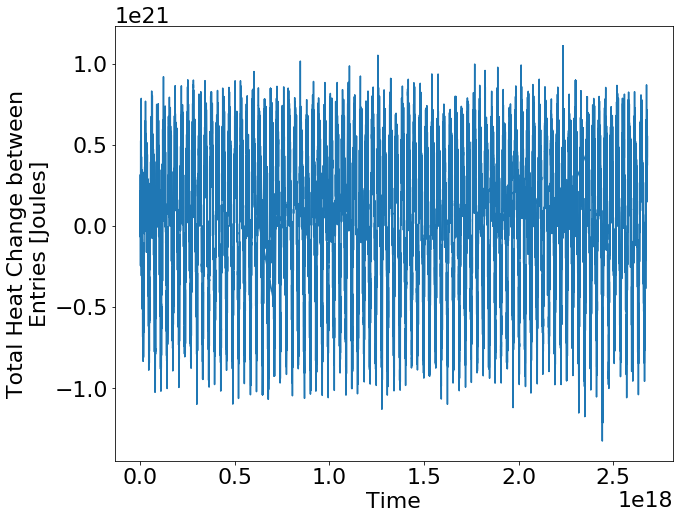

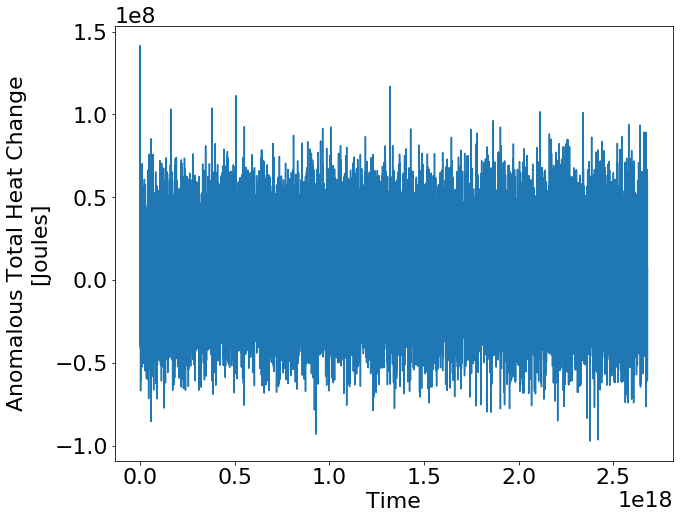

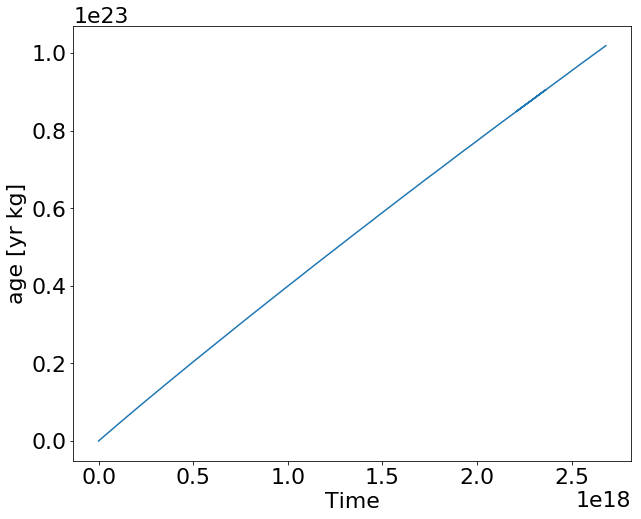

In [351]:
for var in df_stats.variables:
    #print(var)
    if var not in ['KE','APE','H0','Mass_lay','Layer', 'Interface','Time']:
      plt.figure(figsize=(10,8))
      df_stats[var].plot()